# Auto ML

In [1]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
import utils.plot as plot 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

d:\rockhead_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Load

## columns info

|column name|Description|test input|
|---|---|---|
|borehole_code|시추공 코드|X|
|x|위도|O|
|y|경도|O|
|depth_start|rockhead 시작 심도|output|
|Ground name|지반명- 0: 풍화암, 1: 연암, 2: 보통암, 4: 경암|O|
|Slope|경사|O|
|Aspect|경사방향|O|
|DEM|DEM|O|
|Rock Type|지질도에 따른 rock type|O|
|dis_bin|radius count에 따라 총 구간을 30개로 나눈 group|X|

* Rock type: {0:화성암, 1:퇴적암, 2:변성암}
* dis_bin: radius count 그룹에 따라 evaluation 하기 위한 값

In [ ]:
augmented_df = pd.read_csv('data/241216_augmented_250m.csv')
train_df = pd.read_csv('data/241209_Rockhead_Seoul_train(before_aumentation).csv')
val_df = pd.read_csv('data/241209_Rockhead_Seoul_val(before_aumentation).csv')
test_df = pd.read_csv('data/241209_Rockhead_Seoul_test(before_aumentation).csv')

In [ ]:
augmented_df['rock_type'] = augmented_df['type_num'].astype('category')
augmented_df = augmented_df[['X', 'Y', 'DEM', 'Slope', 'Aspect', 'rock_type', 'RMSE_weight']]

# null drop
augmented_df = augmented_df.dropna()

# one-hot encoding
augmented_df = pd.get_dummies(data=augmented_df, drop_first=True)

# rename
augmented_df.rename(columns={'X': 'x', 'Y':'y', 'Slope': 'slope', 'Aspect':'aspect', 'RMSE_weight':'depth_start'}, inplace=True)

# drop
train_df = train_df.drop(['neighbors', 'nn_bin', 'rock_type_3.0'], axis=1)
val_df = val_df.drop(['neighbors', 'nn_bin', 'rock_type_3.0'], axis=1)
test_df = test_df.drop(['neighbors', 'nn_bin', 'rock_type_3.0'], axis=1)

# column set
augmented_df = augmented_df[train_df.columns]

In [4]:
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8962 entries, 0 to 9691
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              8962 non-null   float64
 1   y              8962 non-null   float64
 2   depth_start    8962 non-null   float64
 3   slope          8962 non-null   float64
 4   aspect         8962 non-null   float64
 5   DEM            8962 non-null   float64
 6   rock_type_1.0  8962 non-null   bool   
 7   rock_type_2.0  8962 non-null   bool   
dtypes: bool(2), float64(6)
memory usage: 507.6 KB


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11144 entries, 0 to 11143
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              11144 non-null  float64
 1   y              11144 non-null  float64
 2   depth_start    11144 non-null  float64
 3   slope          11144 non-null  float64
 4   aspect         11144 non-null  float64
 5   DEM            11144 non-null  float64
 6   rock_type_1.0  11144 non-null  bool   
 7   rock_type_2.0  11144 non-null  bool   
dtypes: bool(2), float64(6)
memory usage: 544.3 KB


In [ ]:
val_df.info()

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183 entries, 0 to 3182
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              3183 non-null   float64
 1   y              3183 non-null   float64
 2   depth_start    3183 non-null   float64
 3   slope          3183 non-null   float64
 4   aspect         3183 non-null   float64
 5   DEM            3183 non-null   float64
 6   rock_type_1.0  3183 non-null   bool   
 7   rock_type_2.0  3183 non-null   bool   
dtypes: bool(2), float64(6)
memory usage: 155.5 KB


C:\Users\user\AppData\Local\Temp\ipykernel_14080\262103387.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, train_df_copy, test_df_copy, augmented_df_copy])


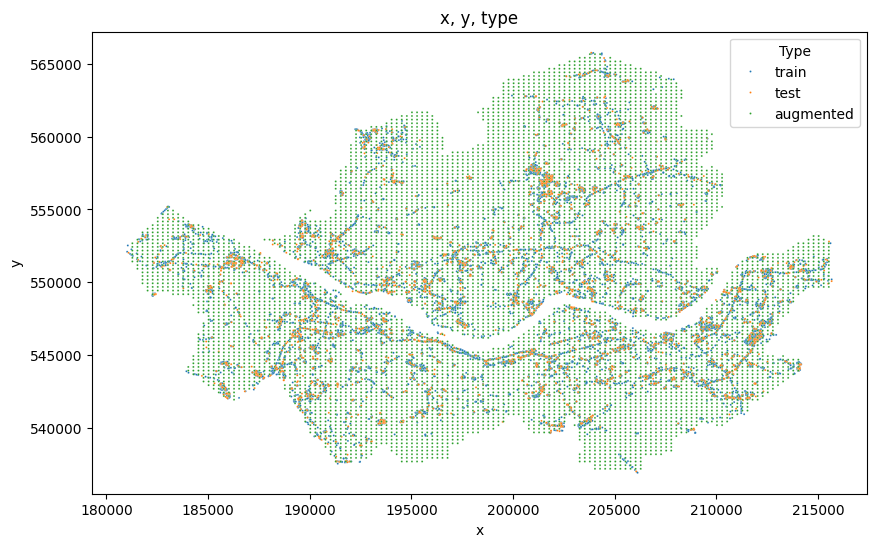

In [ ]:
train_df_copy = train_df.copy()
augmented_df_copy = augmented_df.copy()
val_df_copy = val_df.copy()
test_df_copy = test_df.copy()

augmented_df_copy['Type'] = 'augmented'
train_df_copy['Type'] = 'train'
val_df_copy['Type'] = 'val'
test_df_copy['Type'] = 'test'

df_concat = pd.DataFrame(columns=train_df_copy.columns)
df_concat = pd.concat([df_concat, train_df_copy, test_df_copy, augmented_df_copy, val_df_copy])

plot.scatter_relation(df_concat, 'x', 'y', 2, 'x, y, type','Type')

In [ ]:
train_df = pd.concat([train_df, augmented_df, val_df])
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20106 entries, 0 to 9691
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              20106 non-null  float64
 1   y              20106 non-null  float64
 2   depth_start    20106 non-null  float64
 3   slope          20106 non-null  float64
 4   aspect         20106 non-null  float64
 5   DEM            20106 non-null  float64
 6   rock_type_1.0  20106 non-null  bool   
 7   rock_type_2.0  20106 non-null  bool   
dtypes: bool(2), float64(6)
memory usage: 1.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183 entries, 0 to 3182
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              3183 non-null   float64
 1   y              3183 non-null   float64
 2   depth_start    3183 non-null   float64
 3   slope          3183 non-null   float64
 4   aspect         3183 non-null   flo

## Pre-Processing

In [9]:
# # Min Max Scaling: x, y, slope, DEM
# column_to_scale = ['x', 'y', 'slope', 'aspect', 'DEM']

# scaler = MinMaxScaler()

# # train_dataset
# train_df[column_to_scale] = scaler.fit_transform(train_df[column_to_scale])
# train_df['depth_start'] = train_df['depth_start']

# # test_dataset
# test_df[column_to_scale] = scaler.fit_transform(test_df[column_to_scale])
# test_df['depth_start'] = test_df['depth_start']

# display(train_df.describe())
# display(test_df.describe())

C:\Users\user\AppData\Local\Temp\ipykernel_14080\4247111795.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, train_df, test_df])


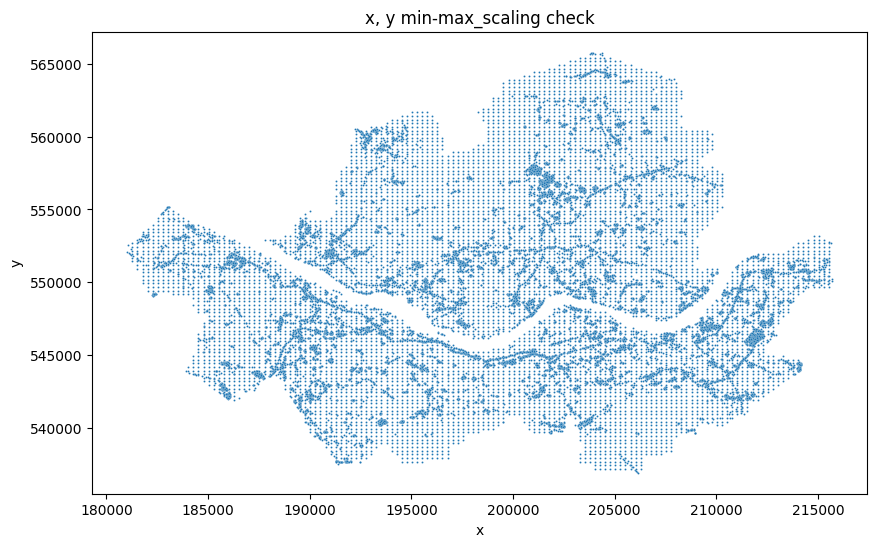

In [ ]:
# df_concat = pd.DataFrame(columns=train_df.columns)
# df_concat = pd.concat([df_concat, train_df, test_df])
# plot.scatter_relation(df_concat, 'x', 'y', 2, 'x, y min-max_scaling check')

In [11]:
train = TabularDataset(train_df)
test = TabularDataset(test_df)
X_test = TabularDataset(test_df.drop(['depth_start'], axis=1))
y_test = test_df['depth_start'].values.tolist()

## Training-Validation

In [12]:
predictor = TabularPredictor(label='depth_start', 
                             problem_type = 'regression', 
                             eval_metric='r2',
                             verbosity =2 
                             )

predictor.fit(train,
              num_gpus=1,
              time_limit = 3600*24, 
              presets="best_quality", 
              save_space = True, 
              keep_only_best = True,
              save_bag_folds = True,
              ag_args_fit = {'num_gpus': 1} # Train with GPU, # 140 models without gpu, 84 models with gpu during 3600*10(241026), 120 models with gpu during 3600*14(241028)
              )

No path specified. Models will be saved in: "AutogluonModels\ag-20241214_153738"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
Memory Avail:       22.52 GB / 31.93 GB (70.5%)
Disk Space Avail:   529.76 GB / 931.51 GB (56.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdo

In [13]:
ld_board = predictor.leaderboard(test, silent=True)

ld_board

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI_r145_BAG_L2,0.864651,0.921845,r2,159.284248,373.314285,41750.337341,1.054684,0.414569,317.108164,2,True,113
1,NeuralNetFastAI_r95_BAG_L2,0.864599,0.921623,r2,159.265745,373.313284,41754.887391,1.036181,0.413568,321.658214,2,True,115
2,NeuralNetFastAI_r191_BAG_L2,0.864577,0.921828,r2,159.057709,373.158262,41644.194786,0.828145,0.258546,210.965609,2,True,111
3,WeightedEnsemble_L3,0.864372,0.923009,r2,164.177964,380.390519,43475.057830,0.012002,0.001000,0.266047,3,True,120
4,ExtraTreesMSE_BAG_L2,0.863406,0.920741,r2,158.682645,374.429483,41451.169824,0.453081,1.529768,17.940646,2,True,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,NeuralNetFastAI_r88_BAG_L1,0.671776,0.714251,r2,0.478084,0.083511,88.623847,0.478084,0.083511,88.623847,1,True,66
116,NeuralNetFastAI_r156_BAG_L1,0.652275,0.692629,r2,0.385693,0.071012,67.924170,0.385693,0.071012,67.924170,1,True,41
117,NeuralNetFastAI_r111_BAG_L1,0.652159,0.688330,r2,0.420621,0.076013,57.227109,0.420621,0.076013,57.227109,1,True,62
118,NeuralNetFastAI_r4_BAG_L1,0.630264,0.671451,r2,0.748391,0.196033,169.759903,0.748391,0.196033,169.759903,1,True,96


## Prediction

In [14]:
pred_y = predictor.predict(X_test, ld_board.model[1])

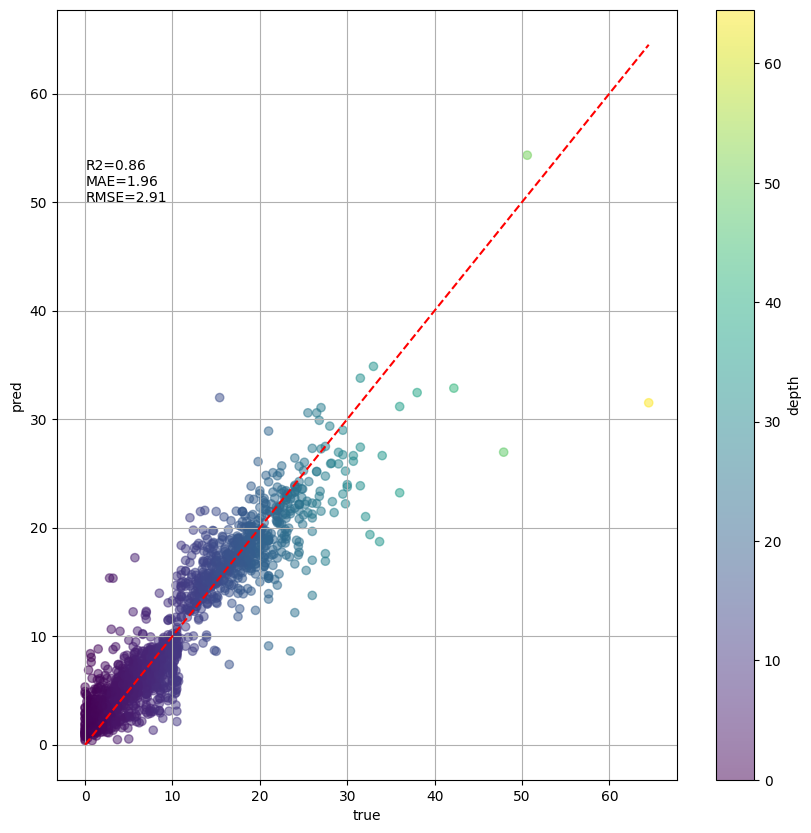

In [3]:
plot.prediction_eval(y_test, pred_y, y_test)